# Step 2: Baseline Model

## Objective

In this step of the project we establish a Baseline Model with minimal feature transformations and simple encoding/filling

## Findings

Through feature importance analysis we found out that the most relevant features seem to be the location features (latitude and longitude) and the time features (date and all features extracted from it).

We also found out that the GaussianNB model seems to be the one that provides the best overall metrics and the least amount of overfitting.

In [1]:
import aux_functions
from transformers import TimeTransformer, BoolTransformer

import json
import joblib
import pickle
import requests

import pandas as pd
pd.set_option('display.max_columns', 100)
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score
# from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, RobustScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, f1_score,  accuracy_score, roc_auc_score, make_scorer, confusion_matrix, roc_curve

# needed to use matplotlib inside jupyter notebook
%matplotlib inline 

# Data Cleaning

In [2]:
df_ = pd.read_csv("data/train.csv")
df_.head(10)

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station
0,2e4d0094-c30b-471b-a211-72a9790feca2,Person search,2020-12-01T01:10:00+00:00,NaN,50.798824,-1.089471,Male,25-34,Other ethnic group - Not stated,White,Police and Criminal Evidence Act 1984 (section 1),Article for use in theft,Community resolution,False,False,hampshire
1,4779fbe8-6e05-4534-85fd-db32952ee309,Person search,2020-12-01T02:00:00+00:00,NaN,50.785099,-1.091540,Male,over 34,White - Any other White background,Other,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False,hampshire
2,cb5c685d-acac-42e2-914d-75e6ff73b0a8,Person search,2020-12-01T09:15:00+00:00,NaN,50.952006,-1.403341,Male,over 34,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,True,hampshire
3,f486e116-5b1e-45db-9931-a7f070c5c478,Person search,2020-12-01T10:20:00+00:00,NaN,50.806383,-1.079844,Male,10-17,Other ethnic group - Not stated,White,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,A no further action disposal,False,False,hampshire
4,78f4020e-12cc-4889-bf1a-2f2c29b2f662,Person search,2020-12-01T10:24:00+00:00,NaN,50.806670,-1.081982,Male,10-17,Other ethnic group - Not stated,Asian,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,A no further action disposal,False,False,hampshire
5,769ac39b-cfe7-4587-855f-b574cdd46933,Person search,2020-12-01T10:30:00+00:00,NaN,50.808359,-1.079465,Male,18-24,Mixed/Multiple ethnic groups - White and Black...,Black,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,Arrest,False,False,hampshire
6,2f3c1b3b-b41a-4b12-b1ab-3c34f93cd20a,Person search,2020-12-01T10:50:00+00:00,NaN,50.914047,-1.401123,Male,over 34,Black/African/Caribbean/Black British - Any ot...,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,True,hampshire
7,b3f957b8-b942-4789-b47c-aa1a6dfcabe7,Person search,2020-12-01T11:00:00+00:00,NaN,50.915304,-1.398959,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False,hampshire
8,79807773-d027-4cdf-ad41-531b3bb2cbab,Person search,2020-12-01T11:10:00+00:00,NaN,50.830251,-1.077629,Male,18-24,Black/African/Caribbean/Black British - Caribbean,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Community resolution,False,False,hampshire
9,fa5f250a-08f0-411d-85ff-eeaab9659cb5,Person search,2020-12-01T11:10:00+00:00,NaN,50.830251,-1.077629,Male,10-17,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False,hampshire


In [3]:
drop_cols = ['Self-defined ethnicity', 'Outcome', 'Outcome linked to object of search', 'Removal of more than just outer clothing']


df_clean = aux_functions.clean_data(df_, drop_cols)

# Train-test Split

In [4]:
df_train, df_test = train_test_split(df_clean, test_size=0.3, random_state=42)

df_train.head()

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,station,target
474137,46a8558a-1c6e-44e0-8c4b-c047d16a6623,Person search,2021-01-11T18:42:00+00:00,<NA>,51.532500,-0.126010,Male,18-24,Other,Misuse of Drugs Act 1971 (section 23),Controlled drugs,btp,0
357002,24a529e4-591f-4b82-9ae8-f75d7a7e4ced,Person search,2021-03-05T16:08:00+00:00,<NA>,53.284603,-2.898138,Male,18-24,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,cheshire,1
455995,c2a13dd4-30a7-4ddf-99b6-8bc045817560,Person search,2021-07-22T22:44:00+00:00,True,50.127423,-5.539860,Male,10-17,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,devon-and-cornwall,0
453885,862710a0-62e2-4dca-9a68-b1cd230664f2,Person search,2021-07-04T15:10:00+00:00,False,51.106259,-0.155093,Male,18-24,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,sussex,0
103957,2e88039c-09ac-47fc-ac97-ed021ac62b6d,Person search,2021-02-28T01:41:49+00:00,<NA>,51.518017,-0.075991,Female,25-34,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,city-of-london,0


# Pipeline Definition

In [5]:
def create_pipeline(df, model):

    y = df["target"].copy()
    X = df.drop(columns=["target"]).copy()

    # Encode Target data
    # lb = LabelEncoder()
    # lb.fit(y)
    # y_bin = pd.DataFrame(data= lb.transform(y), columns= ['readmitted'])

    # categorical_cols = list(X.select_dtypes(include=['object']).columns)
    # numerical_cols = list(X.select_dtypes(include=['number']).columns)
    time_cols = ['Date']

    categorical_cols = ['Type', 'Gender', 'Age range', 'Officer-defined ethnicity', 'Legislation', 'Object of search', 'station']
    
    bool_cols = ['Part of a policing operation']

    numerical_cols = ['Latitude', 'Longitude']

    # Define timeseries pipeline
    time_pipe = Pipeline([
            ('time_transformer', TimeTransformer())
        ])

    # Define categorical pipeline
    cat_pipe = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
        ])
    
    # Define boolean pipeline
    bool_pipe = Pipeline([
            # ('imputer', SimpleImputer(strategy='constant', fill_value=False)),
            ('bool_transformer', BoolTransformer())
        ])

    # Define numerical pipeline
    numeric_pipe = Pipeline([
            ('imputer', SimpleImputer()),
            ('scaler', StandardScaler())
        ])

    
    # Combine categorical and numerical pipelines
    preprocessor = ColumnTransformer([
        ('time_transformer', time_pipe, time_cols),
        ('cat', cat_pipe, categorical_cols),
        ('bool', bool_pipe, bool_cols),
        ('num', numeric_pipe, numerical_cols)],
    remainder='drop')


    # Fit a pipeline with transformers and an estimator to the training data
    pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])
 

    pipeline.fit(X, np.ravel(y))
    # pipeline.fit(X, np.ravel(y_bin))


    return pipeline, X, y


def see_cross_val(pipeline, X, y):

    prec_scorer = make_scorer(precision_score)

    roc_aucs = cross_val_score(pipeline, X, np.ravel(y), cv=5, scoring=prec_scorer)
    print(roc_aucs)

# Check Feature Importance

In [6]:
model = RandomForestClassifier()

pipeline, X_train, y_train = create_pipeline(df_train, model)

Feature ranking:
1. feature Latitude (0.160446)
2. feature Longitude (0.157291)
3. feature day (0.150415)
4. feature hour (0.135351)
5. feature month (0.103804)
6. feature day of the week (0.085700)
7. feature station (0.057524)
8. feature Age range (0.037997)
9. feature Officer-defined ethnicity (0.029977)
10. feature Object of search (0.022653)
11. feature year (0.018574)
12. feature Legislation (0.012076)


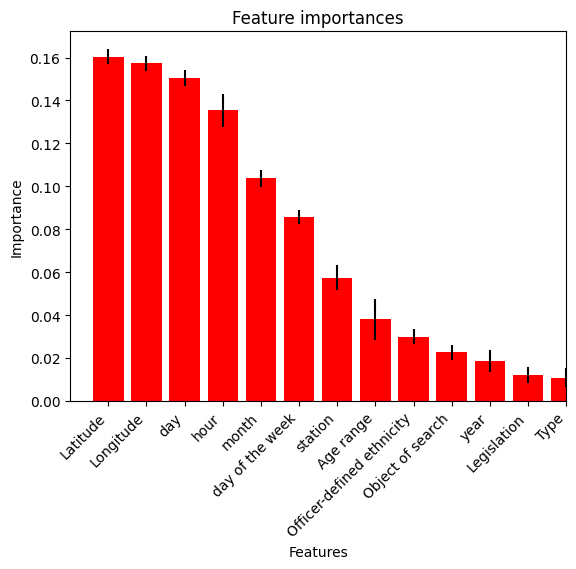

In [7]:
columns=['day', 'month', 'year', 'hour', 'day of the week','Type', 'Gender', 'Age range', 
        'Officer-defined ethnicity', 'Legislation', 'Object of search', 'station',
        'Part of a policing operation',
        'Latitude', 'Longitude']


random_forest_step = pipeline.named_steps['model']

importances = pd.Series(data=random_forest_step.feature_importances_, index = np.array(columns))

indices = np.argsort(importances)[::-1]
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, importances.index[indices[f]], importances[indices[f]]))

std = np.std([tree.feature_importances_ for tree in random_forest_step.estimators_], axis=0)

plt.figure()
plt.title("Feature importances")
plt.bar(x=importances.index[indices], height=importances[indices],
        color="r", yerr=std[indices], align="center");
plt.xticks(range(len(importances.index[indices])), importances.index[indices], rotation=45, ha="right")
plt.xlim([-1, X_train.shape[1]])
plt.xlabel('Features');
plt.ylabel('Importance');

plt.show()


# Train all Models to choose best one

In [8]:
model = GaussianNB()

pipeline, X_train, y_train = create_pipeline(df_train, model)


see_cross_val(pipeline, X_train, y_train)

[0.23809524 0.26742712 0.23410088 0.22156013 0.24725944]


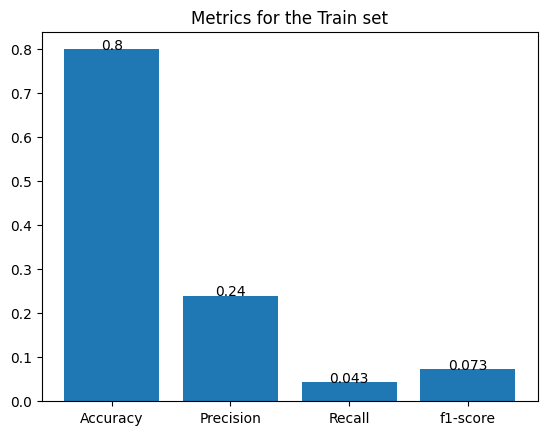

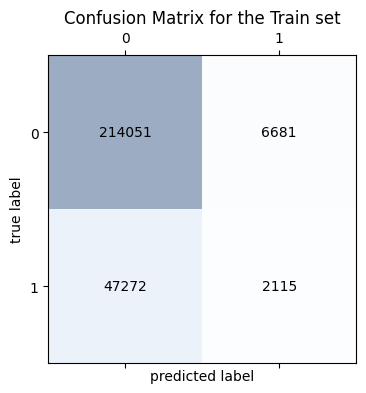

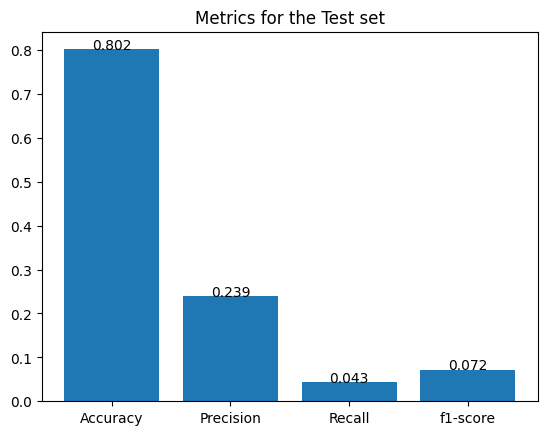

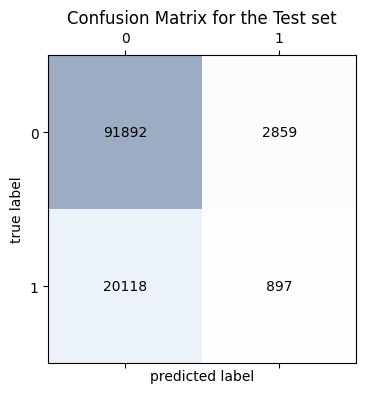

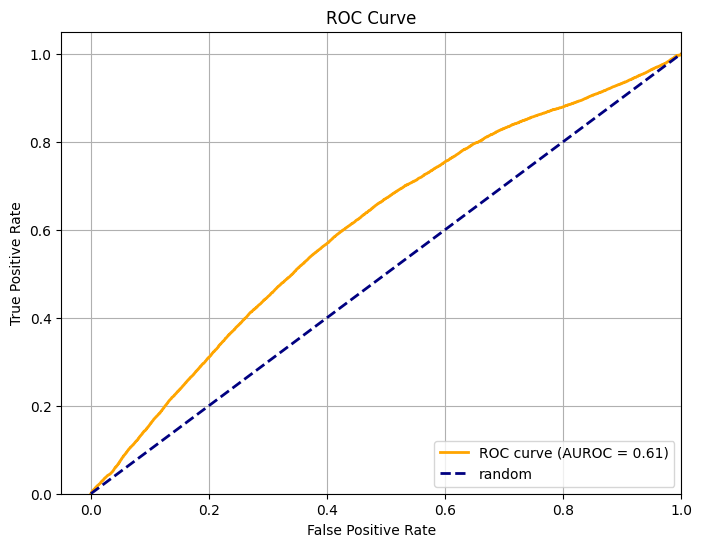

In [9]:
# use the pipeline and get predictions and probas

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred = pipeline.predict(X_test)
# get the probas
y_hat = pipeline.predict_proba(X_test)

# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred)

# show roc_curve

aux_functions.plot_roc_curve(y_test, y_hat)

In [10]:
model = LogisticRegression()

pipeline, X_train, y_train = create_pipeline(df_train, model)


see_cross_val(pipeline, X_train, y_train)

/Users/joaosa/.virtualenvs/cap_prod/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/joaosa/.virtualenvs/cap_prod/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

[0. 0. 0. 0. 0.]


/Users/joaosa/.virtualenvs/cap_prod/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


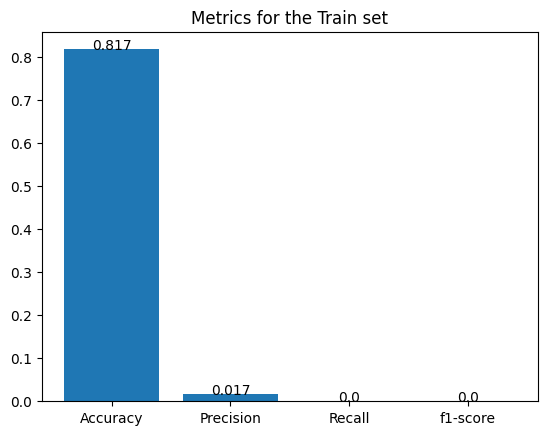

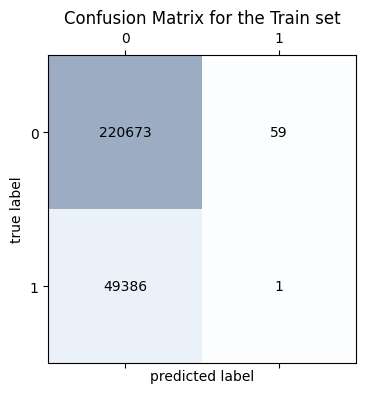

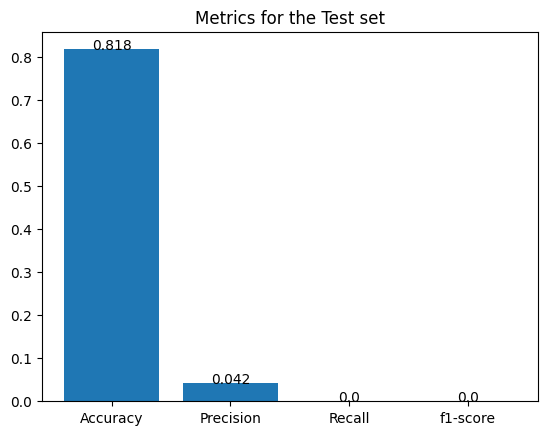

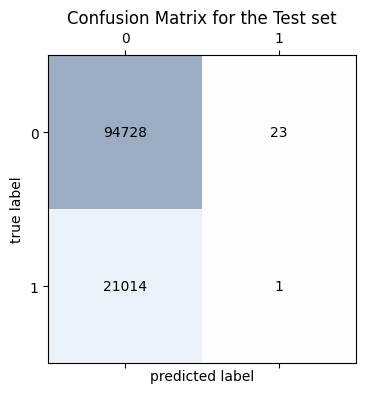

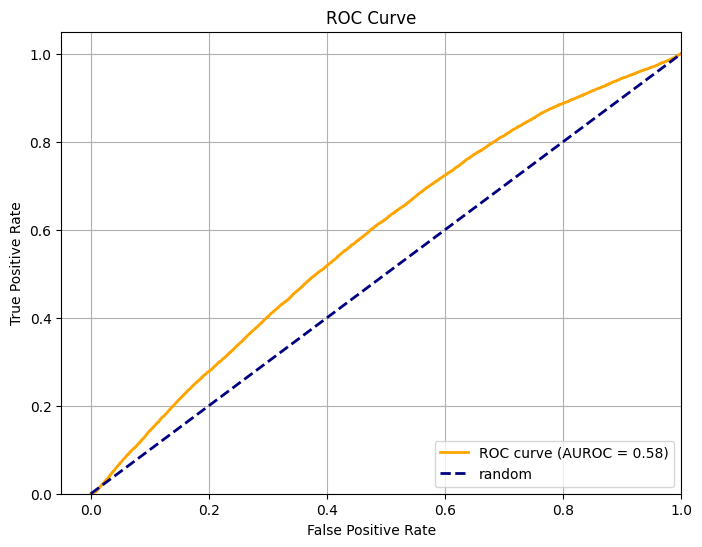

In [11]:
# use the pipeline and get predictions and probas

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred = pipeline.predict(X_test)
# get the probas
y_hat = pipeline.predict_proba(X_test)

# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred)

# show roc_curve

aux_functions.plot_roc_curve(y_test, y_hat)

In [12]:
model = DecisionTreeClassifier()

pipeline, X_train, y_train = create_pipeline(df_train, model)


see_cross_val(pipeline, X_train, y_train)

[0.26210142 0.26370858 0.25938697 0.26791337 0.25860231]


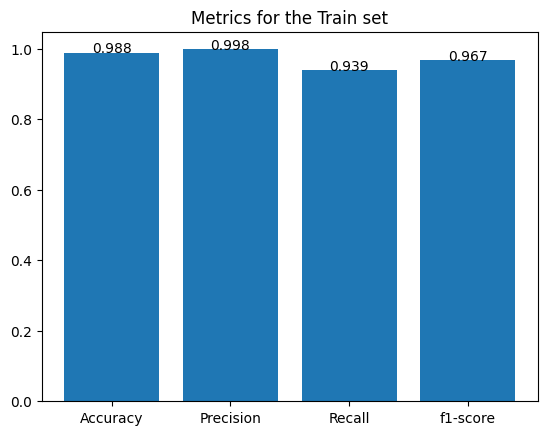

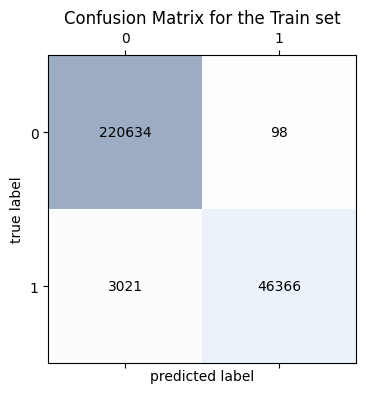

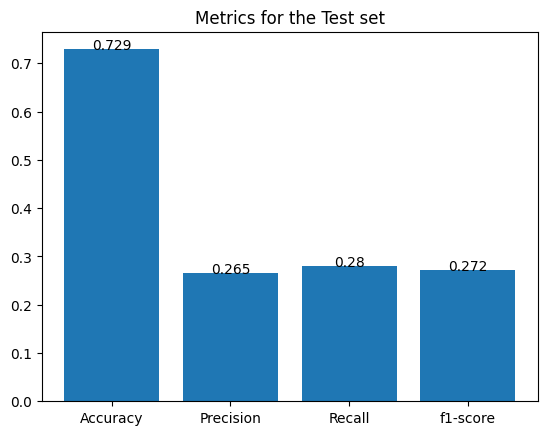

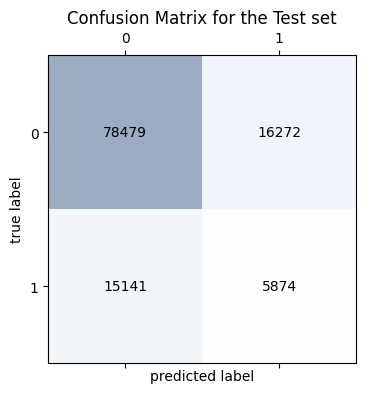

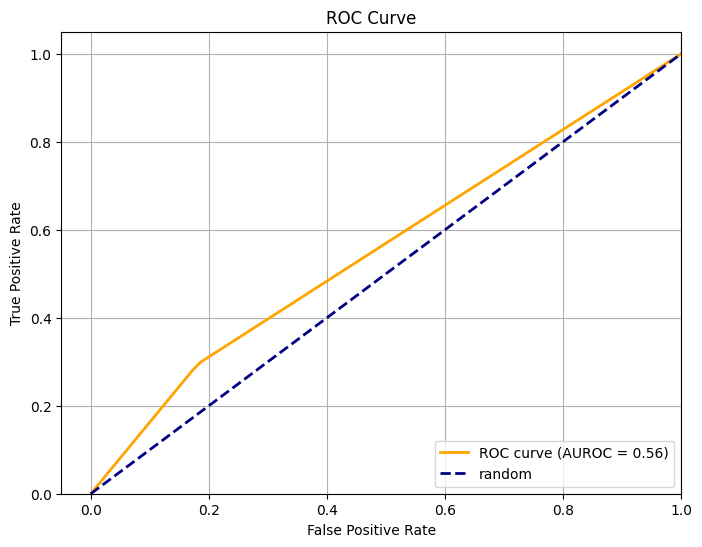

In [13]:
# use the pipeline and get predictions and probas

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred = pipeline.predict(X_test)
# get the probas
y_hat = pipeline.predict_proba(X_test)

# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred)

# show roc_curve

aux_functions.plot_roc_curve(y_test, y_hat)

In [14]:
model = GradientBoostingClassifier()

pipeline, X_train, y_train = create_pipeline(df_train, model)


see_cross_val(pipeline, X_train, y_train)

[0.66666667 0.5        0.         0.5        0.66666667]


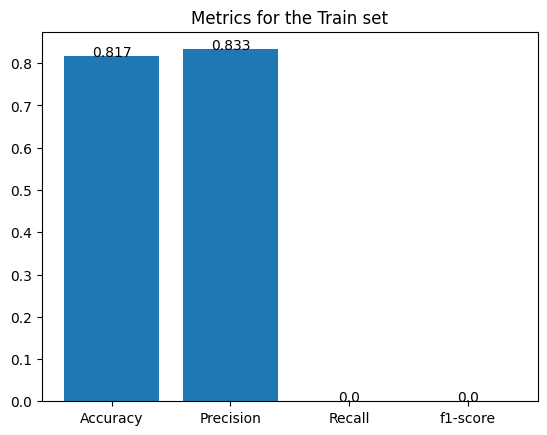

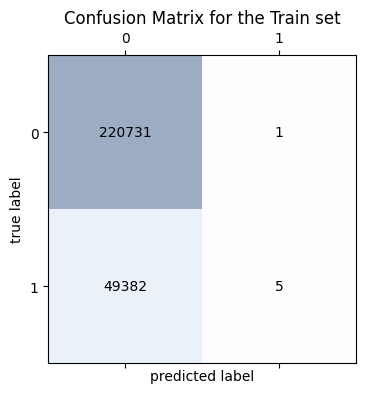

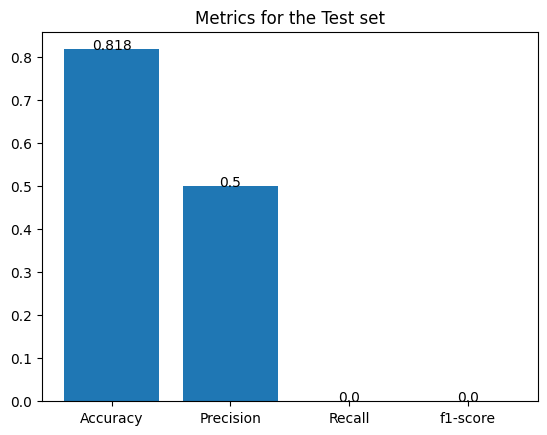

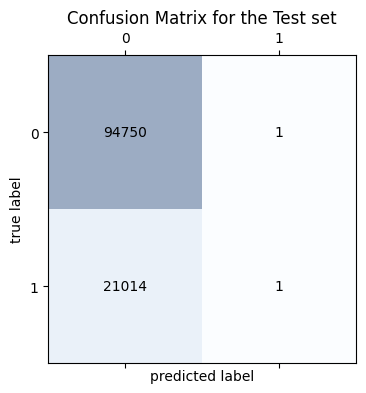

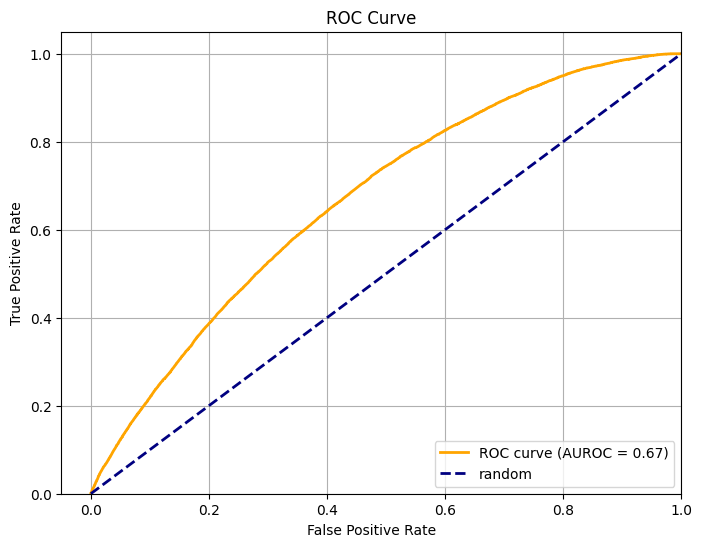

In [15]:
# use the pipeline and get predictions and probas

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred = pipeline.predict(X_test)
# get the probas
y_hat = pipeline.predict_proba(X_test)

# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred)

# show roc_curve

aux_functions.plot_roc_curve(y_test, y_hat)

## Notes on SVC

"The fit time scales at least quadratically with the number of samples and may be impractical beyond tens of thousands of samples. For large datasets consider using LinearSVC or SGDClassifier instead, possibly after a Nystroem transformer or other Kernel Approximation." <a href="https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC">[1]</a>.

In [16]:
# model = SVC()

# pipeline, X_train, y_train = create_pipeline(df_train, model)

# see_cross_val(pipeline, X_train, y_train)

In [17]:
model = LinearSVC()

pipeline, X_train, y_train = create_pipeline(df_train, model)


see_cross_val(pipeline, X_train, y_train)

/Users/joaosa/.virtualenvs/cap_prod/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/joaosa/.virtualenvs/cap_prod/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/joaosa/.virtualenvs/cap_prod/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/joaosa/.virtualenvs/cap_prod/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converg

[0. 0. 0. 0. 0.]


/Users/joaosa/.virtualenvs/cap_prod/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/joaosa/.virtualenvs/cap_prod/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/joaosa/.virtualenvs/cap_prod/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


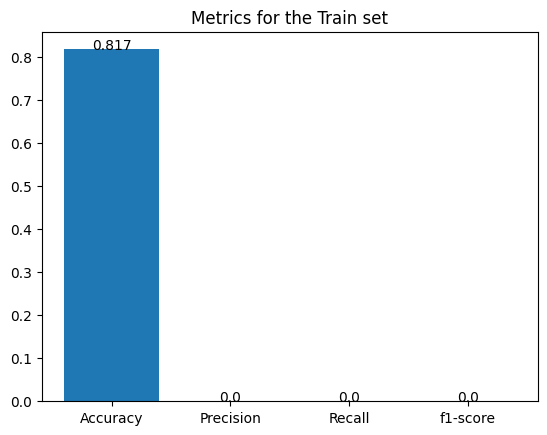

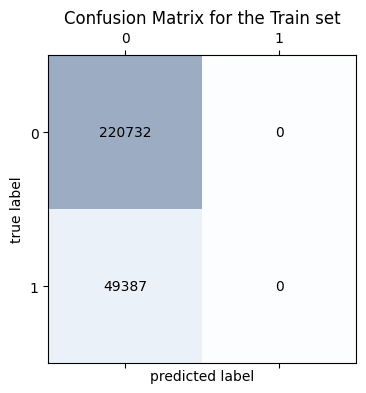

/Users/joaosa/.virtualenvs/cap_prod/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


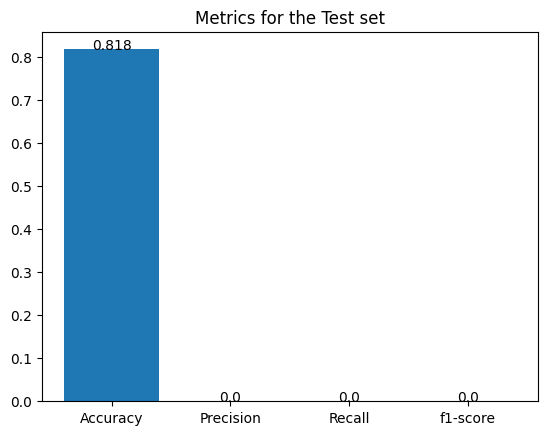

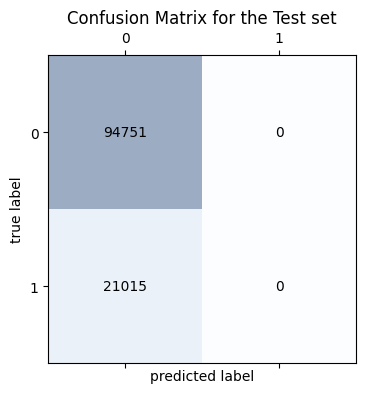

In [18]:
# use the pipeline and get predictions and probas

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred = pipeline.predict(X_test)
# get the probas
#y_hat = pipeline.predict_proba(X_test)

# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred)

# show roc_curve

#aux_functions.plot_roc_curve(y_test, y_hat)

In [19]:

model = KNeighborsClassifier()

pipeline, X_train, y_train = create_pipeline(df_train, model)


see_cross_val(pipeline, X_train, y_train)

[0.29822234 0.28346457 0.29364041 0.29843342 0.29173208]


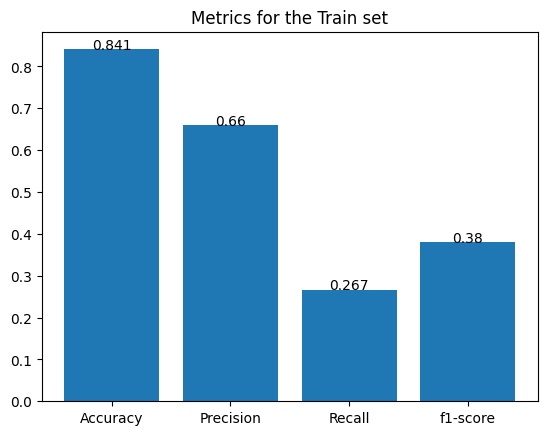

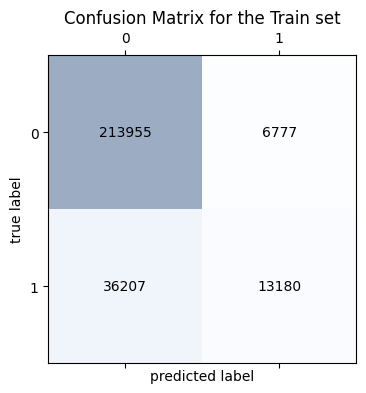

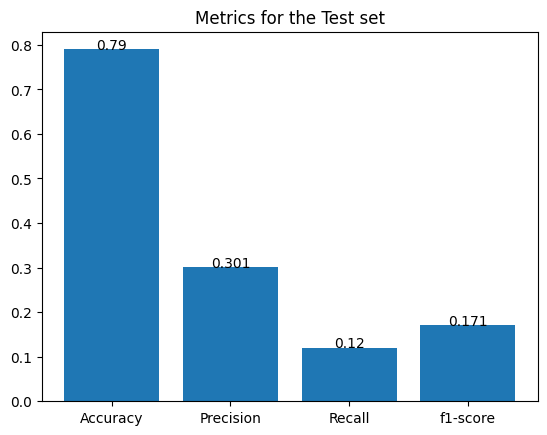

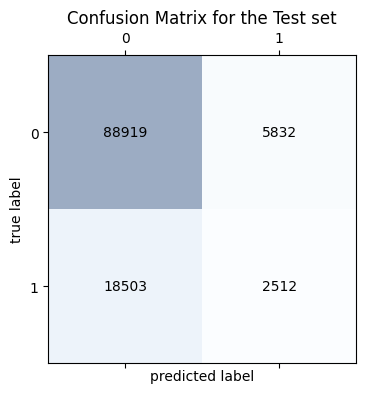

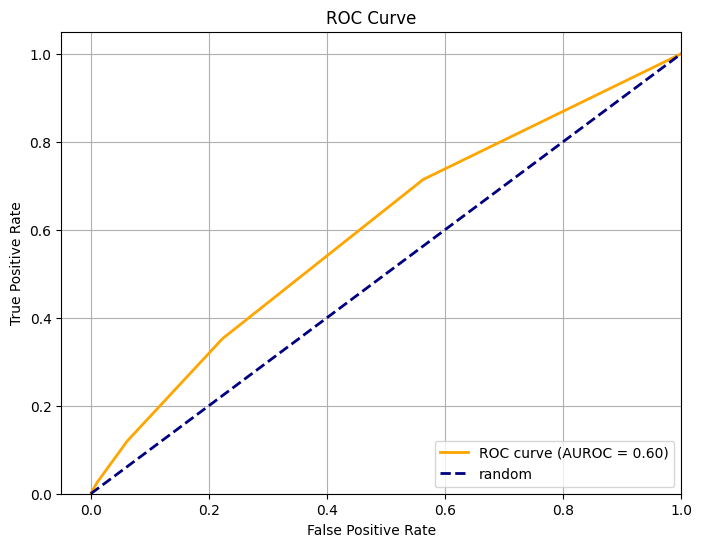

In [20]:
# use the pipeline and get predictions and probas

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred = pipeline.predict(X_test)
# get the probas
y_hat = pipeline.predict_proba(X_test)

# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred)

# show roc_curve

aux_functions.plot_roc_curve(y_test, y_hat)

In [21]:

model = RandomForestClassifier()

pipeline, X_train, y_train = create_pipeline(df_train, model)


see_cross_val(pipeline, X_train, y_train)

[0.37440255 0.3500528  0.36518047 0.37956204 0.36262573]


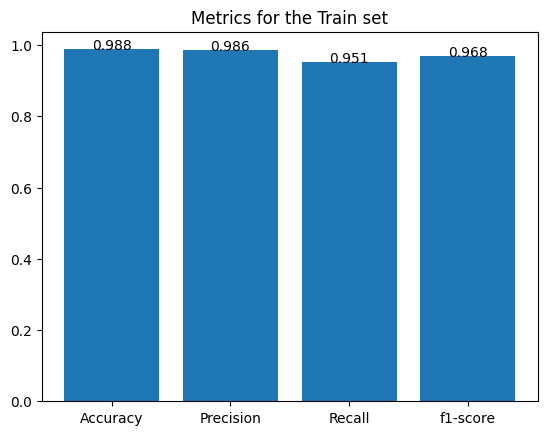

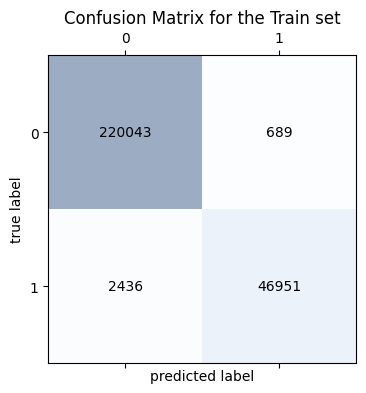

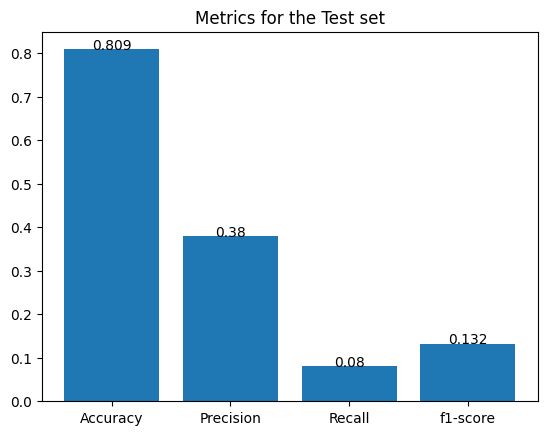

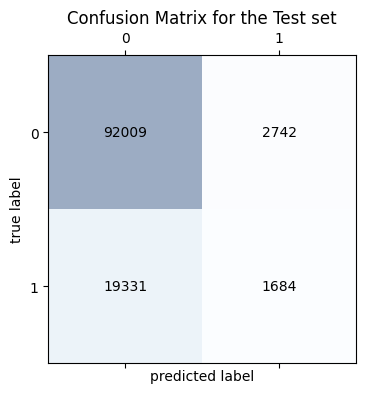

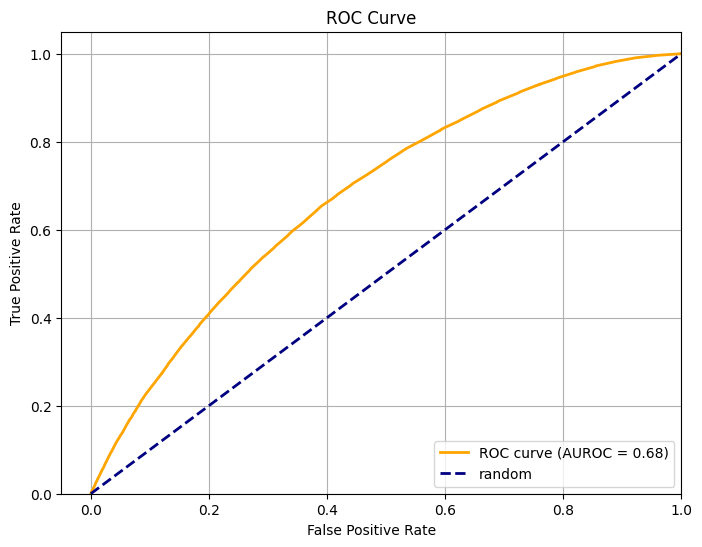

In [22]:
# use the pipeline and get predictions and probas

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred = pipeline.predict(X_test)
# get the probas
y_hat = pipeline.predict_proba(X_test)

# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred)

# show roc_curve

aux_functions.plot_roc_curve(y_test, y_hat)

# Re-train Best Overall Model

In [23]:
model = GaussianNB()

pipeline, X_train, y_train = create_pipeline(df_train, model)


see_cross_val(pipeline, X_train, y_train)

[0.23809524 0.26742712 0.23410088 0.22156013 0.24725944]


In [24]:
# check transformation results

X_df = pd.DataFrame(data=pipeline.named_steps['preprocessor'].transform(X_train), columns=['day', 'month', 'year', 'hour', 'day of the week','Type', 'Gender', 'Age range', 
                                                                                           'Officer-defined ethnicity', 'Legislation', 'Object of search', 'station',
                                                                                            'Part of a policing operation',
                                                                                            'Latitude', 'Longitude'])
X_df

,day,month,year,hour,day of the week,Type,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,station,Part of a policing operation,Latitude,Longitude
0,11,1,2021,18,0,1.0,1.0,1.0,3.0,10.0,3.0,2.0,0.0,-0.863383,1.007755
1,5,3,2021,16,4,1.0,1.0,1.0,4.0,10.0,3.0,4.0,0.0,0.828666,-1.231626
2,22,7,2021,22,3,1.0,1.0,0.0,4.0,12.0,13.0,9.0,1.0,-2.220301,-3.365663
3,4,7,2021,15,6,1.0,1.0,1.0,4.0,10.0,3.0,30.0,0.0,-1.275015,0.984261
4,28,2,2021,1,6,1.0,0.0,2.0,0.0,10.0,3.0,5.0,0.0,-0.87737,1.048162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270114,28,8,2021,23,5,1.0,1.0,3.0,4.0,12.0,16.0,36.0,0.0,-1.002622,-0.539789
270115,18,4,2020,23,5,0.0,1.0,1.0,1.0,10.0,3.0,31.0,0.0,-0.0,-0.0
270116,19,12,2021,0,6,1.0,0.0,1.0,4.0,10.0,3.0,28.0,0.0,-0.0,-0.0
270117,15,3,2021,0,0,1.0,1.0,1.0,4.0,10.0,3.0,26.0,0.0,-0.0,-0.0


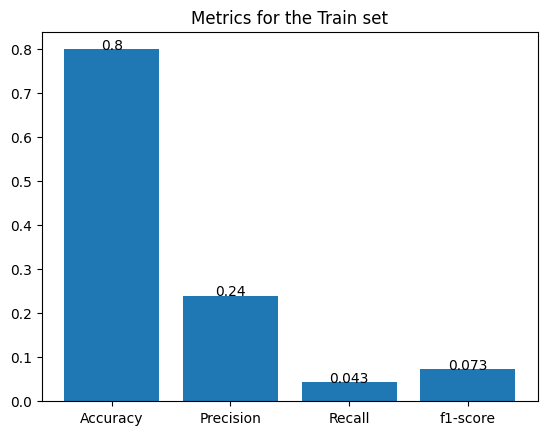

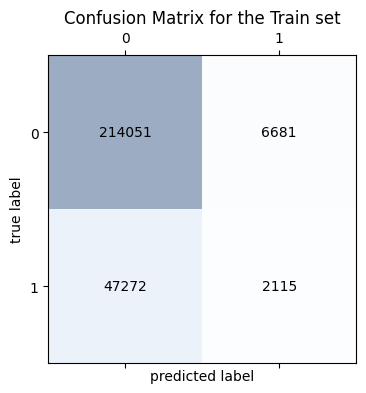

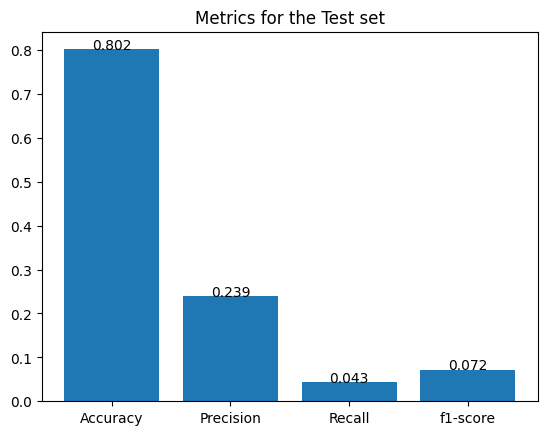

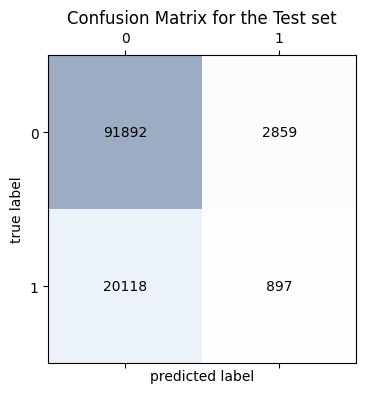

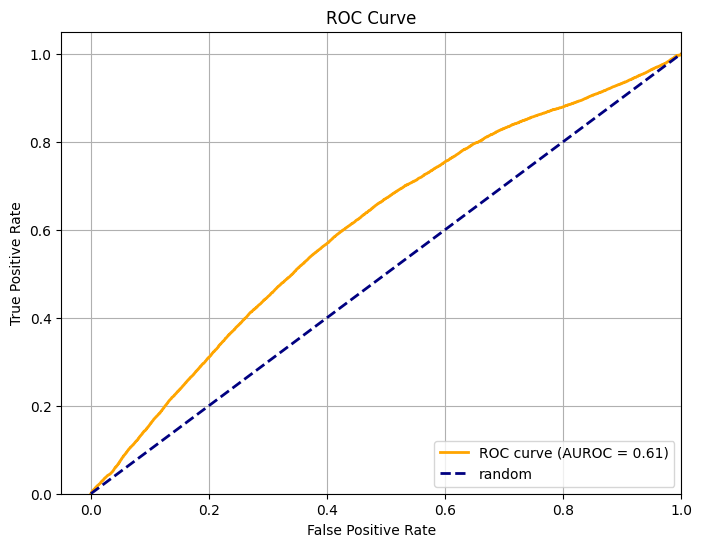

In [25]:
# use the pipeline and get predictions and probas

y_test = df_test["target"].copy()
X_test = df_test.drop(columns=["target"]).copy()

# get the predictions
y_pred_train = pipeline.predict(X_train)
y_pred = pipeline.predict(X_test)
# get the probas
y_hat = pipeline.predict_proba(X_test)

# Train set metrics

aux_functions.show_metrics("Train" ,y_train, y_pred_train)

# Test set metrics

aux_functions.show_metrics("Test", y_test, y_pred)

# show roc_curve

aux_functions.plot_roc_curve(y_test, y_hat)

In [26]:
# Major label percentage

df_clean['target'].value_counts()[0]/len(df_clean['target'])

0.8175570441971054